In [34]:
import pandas as pd
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import LineString
from shapely import wkt
import json
import folium
%matplotlib inline

Loading our data:

In [35]:
# Loading csv straight into geopandas seems to be funky
# So I'll load into pandas first and apply shapely wkt.loads function first
data = pd.read_csv("../data/gis_data.csv")
data_percent = pd.read_csv("../data/gis_data_percent.csv")
data_totals = pd.read_csv('../data/gis_data_totals.csv')

data['geometry'] = data['geometry'].apply(wkt.loads)
data_percent['geometry'] = data_percent['geometry'].apply(wkt.loads)
data_totals['geometry'] = data_totals['geometry'].apply(wkt.loads)

gdf = gpd.GeoDataFrame(data)
gdf_percent = gpd.GeoDataFrame(data_percent)
gdf_totals = gpd.GeoDataFrame(data_totals)

<Axes: >

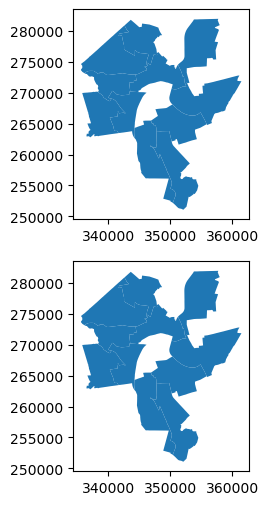

In [36]:
fig, axes = plt.subplots(2,1, figsize=(10,6))
gdf.plot(ax=axes[0])
gdf_percent.plot(ax=axes[1])

<Axes: >

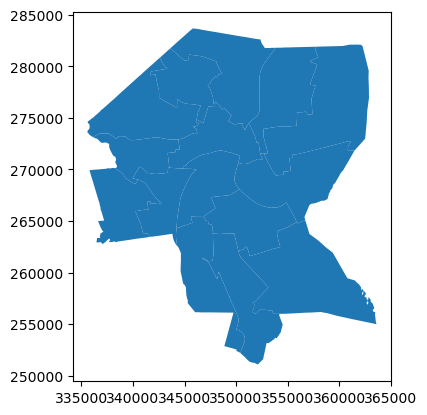

In [37]:
gdf_pvd = gpd.read_file("../data/BND_PVD_Wards_2022.shp")
gdf_pvd.plot()

In [38]:
np.unique(gdf['DISTRICT'])

array([ 1,  3,  5,  6,  7,  8,  9, 11, 12, 14, 15], dtype=int64)

We're missing information on Wards 2, 4, and 13 in our data, which reflects in the plot. Maybe we can add them back in but with NA values?

In [39]:
districts = [2,4,13]
for district in districts:
    gdf = pd.concat([gdf, gdf_pvd.iloc[[district-1]]])
    gdf_percent = pd.concat([gdf_percent, gdf_pvd.iloc[[district-1]]])
    gdf_totals = pd.concat([gdf_totals, gdf_pvd.iloc[[district-1]]])

c:\Users\DWang\anaconda3\envs\evc\Lib\site-packages\geopandas\array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as NAD83(2011) / Rhode Island (ftUS) (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
c:\Users\DWang\anaconda3\envs\evc\Lib\site-packages\geopandas\array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as NAD83(2011) / Rhode Island (ftUS) (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
c:\Users\DWang\anaconda3\envs\evc\Lib\site-packages\geopandas\array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as NAD83(2011) / Rhode Island (ftUS) (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


In [40]:
gdf = gdf.set_index("ID").sort_index()
gdf_percent = gdf_percent.set_index("ID").sort_index()
gdf_totals = gdf_totals.set_index("ID").sort_index()

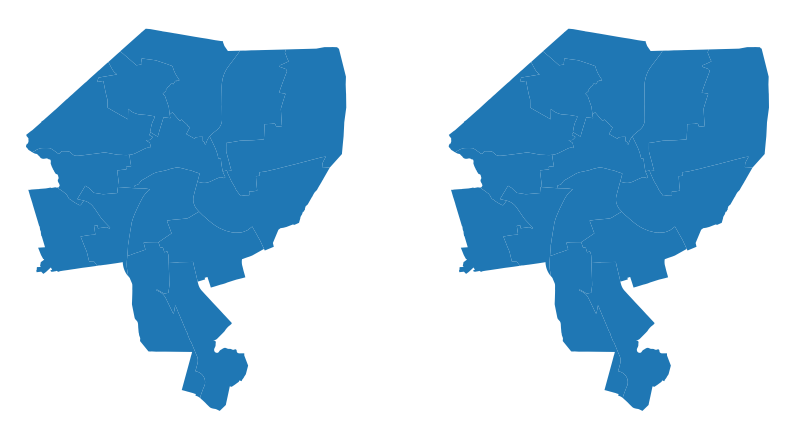

In [41]:
fig, axes = plt.subplots(1,2, figsize=(10,6))
gdf.plot(ax=axes[0])
gdf_percent.plot(ax=axes[1])
axes[0].set_axis_off()
axes[1].set_axis_off()

Playing around with the plotting options

Text(0.5, 1.0, 'Q19_Definitely Not')

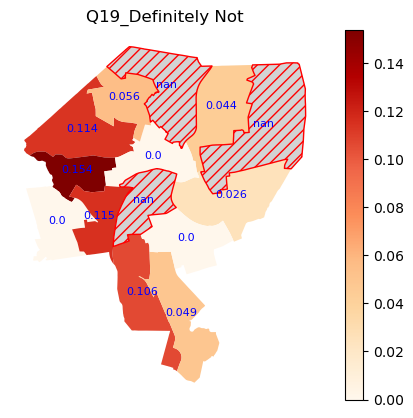

In [42]:
column_name = 'Q19_Definitely Not'
ax = gdf_percent.plot(
    column=column_name,
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values"
    }, cmap="OrRd")
ax.set_axis_off()

for idx, row in gdf_percent.iterrows():
    plt.text(x=row.geometry.centroid.x,
             y=row.geometry.centroid.y, 
             s = str(round(row[column_name],3)), 
             fontsize=8,
             color="blue" ,
             ha='center')
plt.title(column_name)

Let's plot the total response counts and percentages per ward. This'll tell us if some wards are represented more than others.

Text(0.5, 1.0, 'Total Percentage of Responses by Ward')

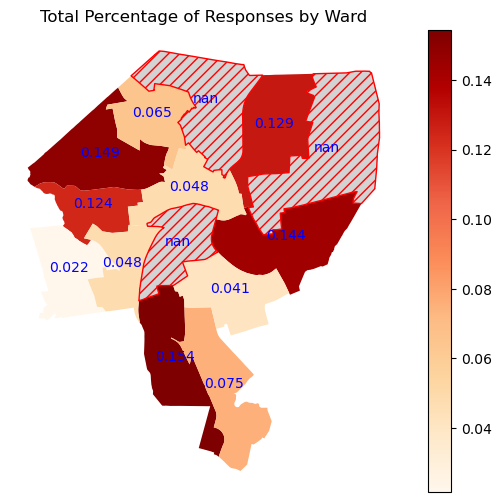

In [ ]:
column_name = 'Percentage' #'Count'
df = gdf_totals 

ax = df.plot(
    column=column_name,
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values"
    }, 
    cmap="OrRd",
    figsize=(8,6))
ax.set_axis_off()

for idx, row in df.iterrows():
    _convert_int = lambda x: int(x) if pd.notna(x) else x
    #ward_string = str(_convert_int(row[column_name]))
    ward_string = str(round(row[column_name],3))
    plt.text(x=row.geometry.centroid.x,
            y=row.geometry.centroid.y, 
            s = ward_string, 
            fontsize=10,
            color="blue",
            ha='center')
plt.title(f"Total {column_name} of Responses by Ward")

Can we combine column values in the maps? E.g. if we wanted to showcase the number/proportion of people in each ward that voted "Probably" OR "Definitely"?

Can we parameterize the inputs so that it's easy to swap questions in and out? Could be useful for dashboarding.

In [55]:
with open("../data/question_mapping.json", "r") as f:
    question_mapping = json.load(f)

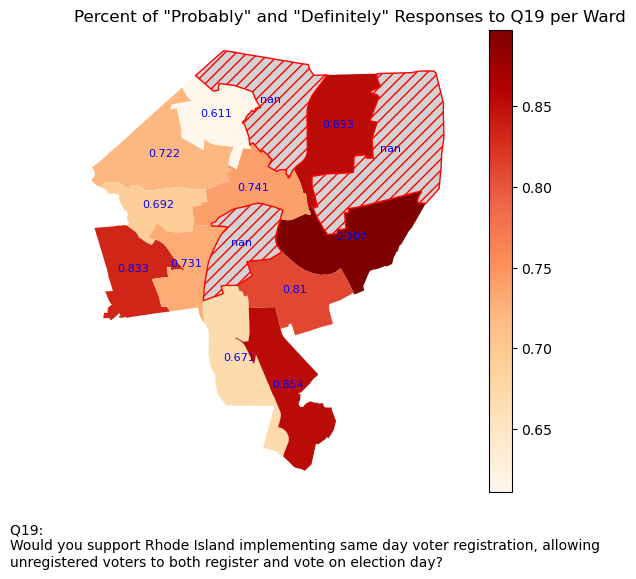

In [ ]:
def print_plot(
        question_number: int,
        question_choices: list,
        percent_df: bool = False
) -> None:
    if percent_df: 
        df = gdf_percent
        measure = "Percent"
    else: 
        df = gdf
        measure = "Count"
    plotting_df = gdf.iloc[:,0:5].copy()
    value_df = pd.DataFrame(0, columns = ['plot_value'], index=df.index)

    for choice in question_choices:
        column_name = f"Q{question_number}_{choice}"
        temp_df = np.array(df[column_name]).reshape(-1)
        value_df['plot_value'] += temp_df
    plotting_df['plot_value'] = value_df['plot_value']

    ax = plotting_df.plot(
        column="plot_value",
        legend=True,
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "///",
            "label": "Missing values"
        }, cmap="OrRd",
        figsize=(7,6))
    ax.set_axis_off()

    
    for idx, row in plotting_df.iterrows():
        _convert_int = lambda x: int(x) if pd.notna(x) else x
        if percent_df: ward_string = str(round(row["plot_value"],3))
        else: ward_string = str(_convert_int(row["plot_value"]))
        plt.text(x=row.geometry.centroid.x,
                y=row.geometry.centroid.y, 
                s = ward_string, 
                fontsize=8,
                color="blue" ,
                ha='center')
    plt.title(loc='left', label=f'{measure} of "Probably" and "Definitely" Responses to Q{question_number} per Ward')
    plt.figtext(0.1, -0.01, f"Q{question_number}: \n{question_mapping[f'Q{question_number}']}", wrap = True)

print_plot(19, ['Probably', 'Definitely'], True)

Dashboarding TODO:

- Build in Dash (from Plotly)

- Deploy to Heroku or free alternative (alwaysdata.com?)

In [ ]:
question_number = "Q4"
question_text = question_mapping[question_number]
popups = [column for column in gdf_percent.columns if question_number in column]
popups.insert(0, "Q1")

m = gdf_percent.explore(
    column=popups[0],  # make choropleth based on "POP2010" column
    cmap='Purples',
    scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    legend=True,  # show legend
    k=6,  # bins of values
    tooltip="DISTRICT",  # hide tooltip
    popup=popups,  # show popup (on-click)
    legend_kwds=dict(colorbar=False),  # do not use colorbar
    name=question_number  # name of the layer in the map
)
m

c:\Users\DWang\anaconda3\envs\evc\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\DWang\anaconda3\envs\evc\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\DWang\anaconda3\envs\evc\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\DWang\anaconda3\envs\evc\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\DWang\anaconda3\envs\evc\Lib\subprocess.py", line 1538, in _execute_c